<a href="https://colab.research.google.com/github/nhgowtham/hackathon_gg/blob/main/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Data preprocessing

### Dataset STO

In [ ]:
import os
import numpy as np
import h5py
import matplotlib.pyplot as plt
from tifffile import imread

# === Settings ===
ROOT_DIR = "/home/gowthamnh/hackathon_gg/data/image_data"
DATASETS = {
    "cdte_dataset.h5": "DataSet_CdTe",
    "sto_dataset.h5": "DataSet_STO"
}
N_PREVIEW = 5  # For visual inspection

# === Utils ===
def normalize_percentile(img, pmin=2, pmax=98):
    lo, hi = np.percentile(img, (pmin, pmax))
    return np.clip((img - lo) / (hi - lo), 0, 1)

def extract_label(fname):
    return os.path.basename(fname).split("_")[0].lower()

def find_all_tif_files(folder):
    tif_files = []
    for root, _, files in os.walk(folder):
        for file in files:
            if file.endswith(".tif"):
                tif_files.append(os.path.join(root, file))
    return tif_files

# === Core Processing ===
def process_dataset(out_h5, subfolder):
    input_dir = os.path.join(ROOT_DIR, subfolder)
    all_files = find_all_tif_files(input_dir)
    print(f"📁 Processing {subfolder} ({len(all_files)} images)")

    label_map = {}
    key_list = []
    previews = []

    with h5py.File(out_h5, "w") as f:
        image_group = f.create_group("images")
        label_ds = f.create_group("labels")

        for path in all_files:
            try:
                raw = imread(path)
                if raw.ndim > 2:
                    raw = raw[..., 0]
                raw = np.squeeze(raw).astype(np.float32)
                norm = normalize_percentile(raw)

                fname = os.path.basename(path)
                label = extract_label(fname)
                key = os.path.splitext(fname)[0].lower()

                # Avoid duplicates
                if key in image_group:
                    i = 1
                    while f"{key}_{i}" in image_group:
                        i += 1
                    key = f"{key}_{i}"

                image_group.create_dataset(key, data=norm, compression="gzip")
                label_ds.attrs[key] = label
                key_list.append(key)

                label_map[label] = label_map.get(label, 0) + 1

                if len(previews) < N_PREVIEW:
                    previews.append((raw, norm, label, fname))

            except Exception as e:
                print(f"[ERROR] {path}: {e}")

        f.create_dataset("image_keys", data=np.array(key_list, dtype='S'))

    print(f"✅ Saved to {out_h5}")
    print("📊 Label summary:", label_map)
    return previews

# === Plot ===
def plot_previews(previews, title):
    fig, axs = plt.subplots(len(previews), 2, figsize=(6, 2 * len(previews)))
    for i, (raw, norm, label, fname) in enumerate(previews):
        axs[i, 0].imshow(raw, cmap='viridis')
        axs[i, 0].set_title(f"Original - {fname}")
        axs[i, 1].imshow(norm, cmap='viridis')
        axs[i, 1].set_title(f"Normalized - label: {label}")
    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

# === Execute ===
for out_file, folder in DATASETS.items():
    previews = process_dataset(out_file, folder)
    plot_previews(previews, f"Preview from {out_file}")


In [44]:
import pathlib, re, h5py, numpy as np, tifffile as tiff
from tqdm import tqdm

sto_root = pathlib.Path("data/image_data/DataSet_STO")  # 64x64 tif patches; label prefix in filename
h5_out = pathlib.Path("sto_dataset.h5")
label_regex = re.compile(r"^([A-Za-z0-9]+)_")  # prefix before first underscore

def collect_files(root: pathlib.Path):
    files = sorted([p for p in root.rglob("*.tif")])
    recs = []
    for p in files:
        m = label_regex.match(p.name)
        if not m:
            continue
        recs.append({"path": p, "label": m.group(1)})
    return recs

records = collect_files(sto_root)
labels = sorted({r["label"] for r in records})
label_to_id = {l: i for i, l in enumerate(labels)}
print(f"found {len(records)} files; labels={labels}")

with h5py.File(h5_out, "w") as f:
    images_ds = f.create_dataset("images", shape=(len(records), 64, 64), dtype="float32")
    labels_ds = f.create_dataset("labels", shape=(len(records),), dtype="int32")
    paths_ds = f.create_dataset("meta/paths", shape=(len(records),), dtype=h5py.string_dtype())
    label_names_ds = f.create_dataset("meta/label_names", data=np.array(labels, dtype="S"))
    for i, rec in enumerate(tqdm(records)):
        img = tiff.imread(rec["path"])
        if img.ndim == 3:
            img = img[..., 0]
        images_ds[i] = img.astype("float32")
        labels_ds[i] = label_to_id[rec["label"]]
        paths_ds[i] = str(rec["path"].relative_to(sto_root))
print("wrote", h5_out)



found 764 files; labels=['Bulk', 'Extra', 'IExtra', 'Mis']


100%|██████████| 764/764 [00:00<00:00, 2087.06it/s]

wrote sto_dataset.h5


# Mask free embedding

In [51]:
# Jupyter cell: MASK-FREE DINOv2 embeddings using top-k patch pooling (no ROI/masks)
import h5py, numpy as np, torch
import torch.nn.functional as F
from PIL import Image

DINO_MODEL = "dinov2_vitb14"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
PATCH_SIZE = 224
batch_size = 128

h5_in  = "sto_dataset.h5"
h5_out = "sto_embeddings_nomask.h5"

IMNET_MEAN = (0.485, 0.456, 0.406)
IMNET_STD  = (0.229, 0.224, 0.225)

# ---- load model ----
model = torch.hub.load("facebookresearch/dinov2", DINO_MODEL).to(DEVICE).eval()

def normalize01(img2d):
    img2d = img2d.astype(np.float32)
    p1, p99 = np.percentile(img2d, (1, 99))
    return np.clip((img2d - p1) / (p99 - p1 + 1e-6), 0, 1)

def pil_to_tensor_no_numpy(pil_img: Image.Image) -> torch.Tensor:
    pil_img = pil_img.convert("RGB")
    w, h = pil_img.size
    b = pil_img.tobytes()
    storage = torch.ByteStorage.from_buffer(b)
    x = torch.ByteTensor(storage).view(h, w, 3).permute(2, 0, 1).contiguous()
    return x.float().div_(255.0)

def preprocess_gray2d_to_dino(img2d, out_size=224):
    # full image -> uint8 RGB
    g01 = normalize01(img2d)
    u8 = (g01 * 255.0 + 0.5).astype(np.uint8)
    rgb = np.repeat(u8[..., None], 3, axis=-1)  # HxWx3

    h, w, _ = rgb.shape
    pil = Image.frombytes("RGB", (w, h), rgb.tobytes())
    x = pil_to_tensor_no_numpy(pil).unsqueeze(0)  # (1,3,H,W)

    x = F.interpolate(x, size=(out_size, out_size), mode="bicubic", align_corners=False)

    mean = torch.tensor(IMNET_MEAN, dtype=x.dtype).view(1, 3, 1, 1)
    std  = torch.tensor(IMNET_STD,  dtype=x.dtype).view(1, 3, 1, 1)
    x = (x - mean) / std
    return x

@torch.inference_mode()
def embed_batch_topk_torch(img2d_list, topk=32):
    xs = [preprocess_gray2d_to_dino(im, out_size=PATCH_SIZE) for im in img2d_list]
    x = torch.cat(xs, dim=0).to(DEVICE, non_blocking=True)  # (B,3,224,224)

    feats = model.forward_features(x)["x_norm_patchtokens"]  # (B, N, D)
    score = torch.linalg.norm(feats, dim=-1)                # (B, N)
    k = min(topk, feats.shape[1])
    idx = torch.topk(score, k=k, dim=1, largest=True).indices  # (B, k)

    B, N, D = feats.shape
    idx_exp = idx.unsqueeze(-1).expand(B, k, D)
    top_tokens = torch.gather(feats, dim=1, index=idx_exp)  # (B,k,D)
    emb = top_tokens.mean(dim=1)                            # (B,D)

    return emb.detach().to("cpu", non_blocking=False).float().contiguous()


# ---- main ----
with h5py.File(h5_in, "r") as fin, h5py.File(h5_out, "w") as fout:
    imgs = fin["images"]
    labels = fin["labels"][:] if "labels" in fin else None
    n = len(imgs)

    emb_dim = 768  # vitb14
    emb_ds = fout.create_dataset("embeddings", shape=(n, emb_dim), dtype="float32", compression="gzip")
    if labels is not None:
        fout.create_dataset("labels", data=labels)

    for k in ["meta/paths", "meta/label_names"]:
        if k in fin:
            fout.create_dataset(k, data=fin[k][:])

    buf, idxs = [], []
    for i in range(n):
        buf.append(imgs[i])
        idxs.append(i)
        if len(buf) == batch_size or i == n - 1:
            emb_t = embed_batch_topk_torch(buf, topk=32)        # torch CPU tensor (B,D)
            emb_np = np.asarray(emb_t.tolist(), dtype=np.float32)  # slow-ish but works without torch<->numpy bridge
            emb_ds[idxs[0]:idxs[0] + len(buf)] = emb_np
            buf, idxs = [], []

print("Saved mask-free embeddings to", h5_out)


Using cache found in /home/gowthamnh/.cache/torch/hub/facebookresearch_dinov2_main
/tmp/ipykernel_1819699/3053228659.py:29: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = torch.ByteStorage.from_buffer(b)


Saved mask-free embeddings to sto_embeddings_nomask.h5


In [52]:
# Jupyter cell: MASK-FREE DINOv2 embeddings using top-k patch pooling (no ROI/masks)
import h5py, numpy as np, torch
import torch.nn.functional as F
from PIL import Image

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DINO_MODEL = "dinov2_vitb14"
PATCH_SIZE = 224
batch_size = 128

h5_in  = "sto_dataset.h5"
h5_out = "sto_embeddings_nomask.h5"

IMNET_MEAN = (0.485, 0.456, 0.406)
IMNET_STD  = (0.229, 0.224, 0.225)

# ---- load model ----
model = torch.hub.load("facebookresearch/dinov2", DINO_MODEL).to(DEVICE).eval()

def normalize01(img2d):
    img2d = img2d.astype(np.float32)
    p1, p99 = np.percentile(img2d, (1, 99))
    return np.clip((img2d - p1) / (p99 - p1 + 1e-6), 0, 1)

def pil_to_tensor_no_numpy(pil_img: Image.Image) -> torch.Tensor:
    pil_img = pil_img.convert("RGB")
    w, h = pil_img.size
    b = pil_img.tobytes()
    storage = torch.ByteStorage.from_buffer(b)
    x = torch.ByteTensor(storage).view(h, w, 3).permute(2, 0, 1).contiguous()
    return x.float().div_(255.0)

def preprocess_gray2d_to_dino(img2d, out_size=224):
    g01 = normalize01(img2d)
    u8 = (g01 * 255.0 + 0.5).astype(np.uint8)
    rgb = np.repeat(u8[..., None], 3, axis=-1)  # HxWx3

    h, w, _ = rgb.shape
    pil = Image.frombytes("RGB", (w, h), rgb.tobytes())
    x = pil_to_tensor_no_numpy(pil).unsqueeze(0)  # (1,3,H,W)
    x = F.interpolate(x, size=(out_size, out_size), mode="bicubic", align_corners=False)

    mean = torch.tensor(IMNET_MEAN, dtype=x.dtype).view(1, 3, 1, 1)
    std  = torch.tensor(IMNET_STD,  dtype=x.dtype).view(1, 3, 1, 1)
    return (x - mean) / std

@torch.inference_mode()
def embed_batch_topk_torch(img2d_list, topk=32):
    xs = [preprocess_gray2d_to_dino(im, out_size=PATCH_SIZE) for im in img2d_list]
    x = torch.cat(xs, dim=0).to(DEVICE, non_blocking=True)  # (B,3,224,224)

    feats = model.forward_features(x)["x_norm_patchtokens"]  # (B, N, D)
    score = torch.linalg.norm(feats, dim=-1)                # (B, N)
    k = min(topk, feats.shape[1])
    idx = torch.topk(score, k=k, dim=1, largest=True).indices  # (B, k)

    B, N, D = feats.shape
    idx_exp = idx.unsqueeze(-1).expand(B, k, D)
    top_tokens = torch.gather(feats, dim=1, index=idx_exp)  # (B,k,D)
    emb = top_tokens.mean(dim=1)                            # (B,D)
    return emb.detach().to("cpu", non_blocking=False).float().contiguous()

# ---- main ----
with h5py.File(h5_in, "r") as fin, h5py.File(h5_out, "w") as fout:
    imgs = get_images_dataset(fin)
    labels = get_labels_array(fin, allow_missing=True)
    label_names = get_label_names(fin)

    n = len(imgs)
    emb_dim = 768
    emb_ds = fout.create_dataset("embeddings", shape=(n, emb_dim), dtype="float32", compression="gzip")

    if labels is not None:
        fout.create_dataset("labels", data=labels)
    if label_names is not None:
        fout.create_dataset("meta/label_names", data=np.array(label_names, dtype="S"))

    # copy other helpful metadata if present
    for k in ["meta/paths", "paths"]:
        if k in fin and isinstance(fin[k], h5py.Dataset):
            fout.create_dataset("meta/paths", data=fin[k][:])

    buf, idxs = [], []
    for i in range(n):
        buf.append(imgs[i])
        idxs.append(i)
        if len(buf) == batch_size or i == n - 1:
            emb_t = embed_batch_topk_torch(buf, topk=32)  # torch CPU (B,D)
            emb_np = np.asarray(emb_t.tolist(), dtype=np.float32)  # bridge-safe
            emb_ds[idxs[0]:idxs[0] + len(buf)] = emb_np
            buf, idxs = [], []

print("Saved mask-free embeddings to", h5_out)


Using cache found in /home/gowthamnh/.cache/torch/hub/facebookresearch_dinov2_main
/tmp/ipykernel_1819699/3783752214.py:29: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = torch.ByteStorage.from_buffer(b)


Saved mask-free embeddings to sto_embeddings_nomask.h5


### Self supervised embedding

Using cache found in /home/gowthamnh/.cache/torch/hub/facebookresearch_dinov2_main
/tmp/ipykernel_1819699/3488939480.py:62: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = torch.ByteStorage.from_buffer(b)


[OK] Saved mask-free embeddings: sto_embeddings_nomask_k32.h5 (topk=32)

=== MASK-FREE Embeddings (topk=32) ===
Embeddings shape: (764, 768) dtype: float32
Global mean: -0.05568652227520943 Global std: 1.5048335790634155

Per-class stats:
                Bulk | n=  225 | mean=-0.0542 | std=1.5169
               Extra | n=  195 | mean=-0.0569 | std=1.4852
              IExtra | n=  143 | mean=-0.0563 | std=1.5022
                 Mis | n=  201 | mean=-0.0557 | std=1.5120


/home/gowthamnh/miniforge3/envs/dinov2-extras/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


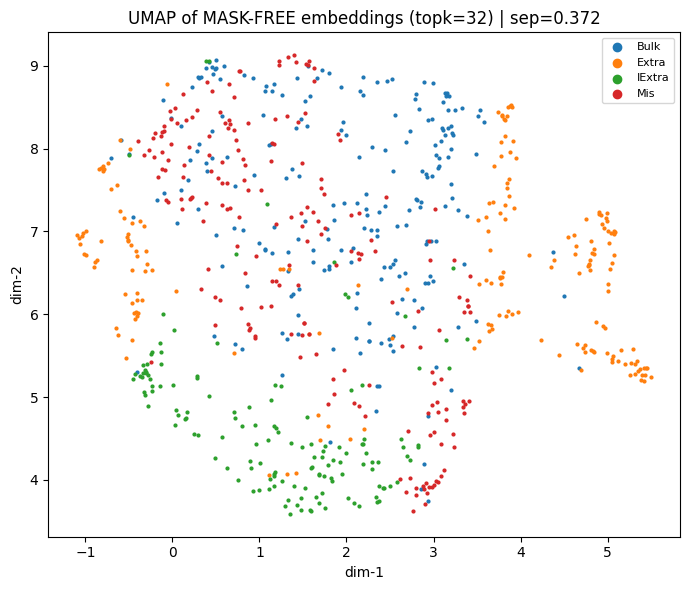


=== TOP-K SENSITIVITY SWEEP ===


/home/gowthamnh/miniforge3/envs/dinov2-extras/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


topk=  8 | UMAP                                     | sep=0.0499


/home/gowthamnh/miniforge3/envs/dinov2-extras/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


topk= 16 | UMAP                                     | sep=0.2847


/home/gowthamnh/miniforge3/envs/dinov2-extras/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


topk= 32 | UMAP                                     | sep=0.3721


/home/gowthamnh/miniforge3/envs/dinov2-extras/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


topk= 64 | UMAP                                     | sep=0.2383


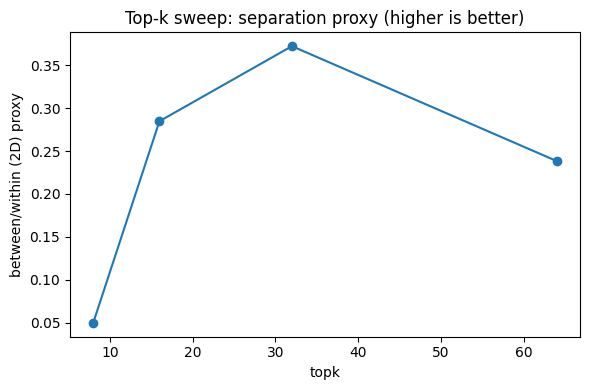


=== ROI vs NO-MASK COMPARISON ===


/home/gowthamnh/miniforge3/envs/dinov2-extras/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/gowthamnh/miniforge3/envs/dinov2-extras/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


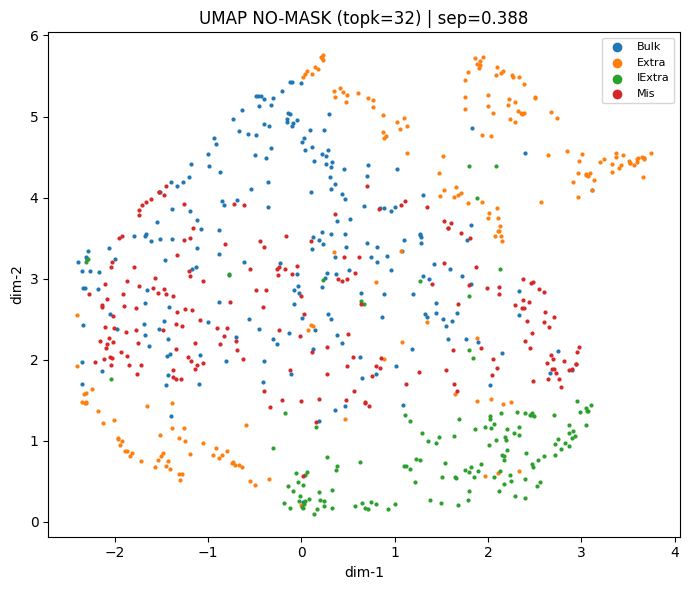

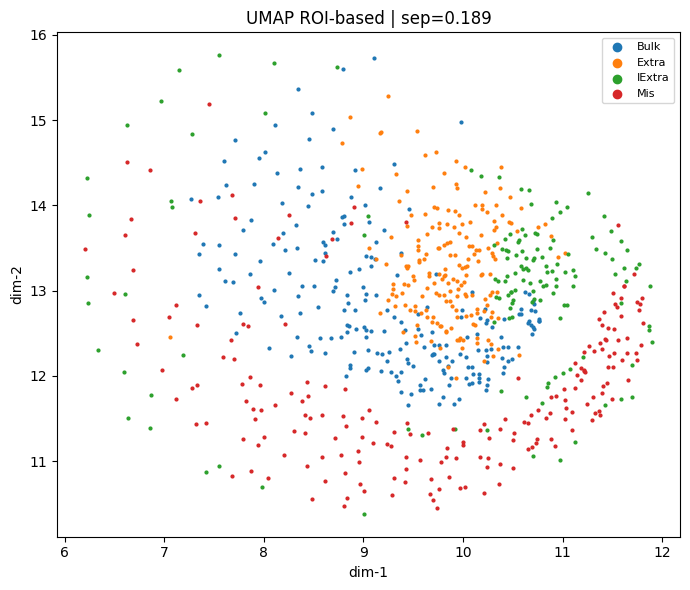

NO-MASK sep=0.3882 | ROI sep=0.1895


In [54]:
# Jupyter cell: MASK-FREE DINOv2 embeddings (top-k patch pooling) + analysis (UMAP + top-k sweep) + optional ROI vs no-mask comparison
# - No masks/ROI required
# - Avoids torch->numpy bridge (RuntimeError: Numpy is not available) by using .tolist() conversion
# - Produces: sto_embeddings_nomask_k32.h5 (and optionally multiple ks)
# - Analysis:
#   (A) Per-class embedding stats (if labels + meta/label_names exist)
#   (B) UMAP 2D visualization (uses umap-learn; will fall back to PCA if missing)
#   (C) Top-k sensitivity sweep: k in {8,16,32,64}
#   (D) ROI vs no-mask UMAP comparison if sto_embeddings_roi.h5 exists

import os, h5py, numpy as np, torch
import torch.nn.functional as F
from PIL import Image

# ----------------------------
# Config
# ----------------------------
DINO_MODEL = "dinov2_vitb14"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
PATCH_SIZE = 224
batch_size = 64  # lower to reduce CPU <-> GPU overhead and .tolist() cost

h5_in = "sto_dataset.h5"

# main output (single-k run)
TOPK_MAIN = 32
h5_out_main = f"sto_embeddings_nomask_k{TOPK_MAIN}.h5"

# sweep settings (set to None to disable)
TOPK_SWEEP = [8, 16, 32, 64]   # comment out to disable sweep
DO_SWEEP = True

# optional comparison file (if it exists)
h5_roi = "sto_embeddings_roi.h5"
DO_ROI_COMPARE = os.path.exists(h5_roi)

# If you want to downsample for faster UMAP visualization
MAX_POINTS_FOR_UMAP = 4000

# DINO normalization (ImageNet)
IMNET_MEAN = (0.485, 0.456, 0.406)
IMNET_STD  = (0.229, 0.224, 0.225)

# ----------------------------
# Load DINOv2
# ----------------------------
model = torch.hub.load("facebookresearch/dinov2", DINO_MODEL).to(DEVICE).eval()

# ----------------------------
# Helpers
# ----------------------------
def normalize01(img2d):
    img2d = img2d.astype(np.float32)
    p1, p99 = np.percentile(img2d, (1, 99))
    return np.clip((img2d - p1) / (p99 - p1 + 1e-6), 0, 1)

def pil_to_tensor_no_numpy(pil_img: Image.Image) -> torch.Tensor:
    # returns float tensor CHW in [0,1] using ByteStorage.from_buffer (no torch.from_numpy)
    pil_img = pil_img.convert("RGB")
    w, h = pil_img.size
    b = pil_img.tobytes()
    storage = torch.ByteStorage.from_buffer(b)
    x = torch.ByteTensor(storage).view(h, w, 3).permute(2, 0, 1).contiguous()
    return x.float().div_(255.0)

def preprocess_gray2d_to_dino(img2d, out_size=224):
    g01 = normalize01(img2d)
    u8 = (g01 * 255.0 + 0.5).astype(np.uint8)
    rgb = np.repeat(u8[..., None], 3, axis=-1)  # HxWx3 uint8

    h, w, _ = rgb.shape
    pil = Image.frombytes("RGB", (w, h), rgb.tobytes())
    x = pil_to_tensor_no_numpy(pil).unsqueeze(0)  # (1,3,H,W)

    x = F.interpolate(x, size=(out_size, out_size), mode="bicubic", align_corners=False)

    mean = torch.tensor(IMNET_MEAN, dtype=x.dtype).view(1, 3, 1, 1)
    std  = torch.tensor(IMNET_STD,  dtype=x.dtype).view(1, 3, 1, 1)
    x = (x - mean) / std
    return x

@torch.inference_mode()
def embed_batch_topk_torch(img2d_list, topk=32):
    xs = [preprocess_gray2d_to_dino(im, out_size=PATCH_SIZE) for im in img2d_list]
    x = torch.cat(xs, dim=0).to(DEVICE, non_blocking=True)  # (B,3,224,224)

    feats = model.forward_features(x)["x_norm_patchtokens"]  # (B, N, D)
    score = torch.linalg.norm(feats, dim=-1)                # (B, N)
    k = min(int(topk), feats.shape[1])
    idx = torch.topk(score, k=k, dim=1, largest=True).indices  # (B, k)

    B, N, D = feats.shape
    idx_exp = idx.unsqueeze(-1).expand(B, k, D)
    top_tokens = torch.gather(feats, dim=1, index=idx_exp)  # (B,k,D)
    emb = top_tokens.mean(dim=1)                            # (B,D)

    return emb.detach().to("cpu", non_blocking=False).float().contiguous()

def write_embeddings_nomask(h5_out, topk):
    with h5py.File(h5_in, "r") as fin, h5py.File(h5_out, "w") as fout:
        imgs = fin["images"]
        labels = fin["labels"][:] if "labels" in fin else None
        n = len(imgs)

        emb_dim = 768  # vitb14
        emb_ds = fout.create_dataset("embeddings", shape=(n, emb_dim), dtype="float32", compression="gzip")
        if labels is not None:
            fout.create_dataset("labels", data=labels)

        for k in ["meta/paths", "meta/label_names"]:
            if k in fin:
                fout.create_dataset(k, data=fin[k][:])

        buf, idxs = [], []
        for i in range(n):
            buf.append(imgs[i])
            idxs.append(i)
            if len(buf) == batch_size or i == n - 1:
                emb_t = embed_batch_topk_torch(buf, topk=topk)               # torch CPU tensor
                emb_np = np.asarray(emb_t.tolist(), dtype=np.float32)        # no torch->numpy bridge
                emb_ds[idxs[0]:idxs[0] + len(buf)] = emb_np
                buf, idxs = [], []
    print(f"[OK] Saved mask-free embeddings: {h5_out} (topk={topk})")

def load_embeddings(h5_path):
    with h5py.File(h5_path, "r") as f:
        emb = f["embeddings"][:]
        labels = f["labels"][:] if "labels" in f else None
        names = [x.decode() for x in f["meta/label_names"][:]] if "meta/label_names" in f else None
    return emb, labels, names

def per_class_stats(emb, labels, names, title=""):
    if title:
        print("\n" + title)
    print("Embeddings shape:", emb.shape, "dtype:", emb.dtype)
    print("Global mean:", float(emb.mean()), "Global std:", float(emb.std()))
    if labels is None or names is None:
        print("No labels and/or label_names found -> skipping per-class stats.")
        return
    print("\nPer-class stats:")
    for lid in np.unique(labels):
        m = float(emb[labels == lid].mean())
        s = float(emb[labels == lid].std())
        n = int((labels == lid).sum())
        print(f"{names[int(lid)]:>20s} | n={n:5d} | mean={m:.4f} | std={s:.4f}")

def sample_for_viz(X, y=None, max_points=4000, seed=0):
    n = len(X)
    if n <= max_points:
        return X, y
    rng = np.random.default_rng(seed)
    idx = rng.choice(n, size=max_points, replace=False)
    return X[idx], (y[idx] if y is not None else None)

def umap_or_pca_2d(X, seed=0):
    # Try UMAP; if unavailable, fall back to PCA
    try:
        import umap
        reducer = umap.UMAP(n_components=2, random_state=seed, n_neighbors=30, min_dist=0.05)
        Z = reducer.fit_transform(X)
        method = "UMAP"
        return Z, method
    except Exception as e:
        from sklearn.decomposition import PCA
        Z = PCA(n_components=2, random_state=seed).fit_transform(X)
        method = "PCA (fallback; install umap-learn for UMAP)"
        return Z, method

def plot_2d(Z, labels=None, names=None, title="2D embedding"):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(7, 6))
    if labels is None:
        plt.scatter(Z[:, 0], Z[:, 1], s=4)
    else:
        # plot each class separately for readability
        for lid in np.unique(labels):
            m = labels == lid
            lab = names[int(lid)] if names is not None and int(lid) < len(names) else str(int(lid))
            plt.scatter(Z[m, 0], Z[m, 1], s=4, label=lab)
        plt.legend(markerscale=3, fontsize=8)
    plt.title(title)
    plt.xlabel("dim-1")
    plt.ylabel("dim-2")
    plt.tight_layout()
    plt.show()

def simple_separation_score(Z, labels):
    # quick numeric proxy: ratio of between-class centroid variance to within-class variance
    if labels is None:
        return np.nan
    labs = np.unique(labels)
    centroids = []
    within = []
    for lid in labs:
        Xc = Z[labels == lid]
        centroids.append(Xc.mean(axis=0))
        within.append(((Xc - Xc.mean(axis=0))**2).sum(axis=1).mean())
    centroids = np.stack(centroids, axis=0)
    between = ((centroids - centroids.mean(axis=0))**2).sum(axis=1).mean()
    within = float(np.mean(within))
    return float(between / (within + 1e-12))

# ----------------------------
# 1) Generate embeddings (single-k)
# ----------------------------
write_embeddings_nomask(h5_out_main, TOPK_MAIN)

# ----------------------------
# 2) Sanity stats + UMAP/PCA plot for main file
# ----------------------------
emb, labels, names = load_embeddings(h5_out_main)
per_class_stats(emb, labels, names, title=f"=== MASK-FREE Embeddings (topk={TOPK_MAIN}) ===")

Xviz, yviz = sample_for_viz(emb, labels, max_points=MAX_POINTS_FOR_UMAP, seed=0)
Z, method = umap_or_pca_2d(Xviz, seed=0)
score = simple_separation_score(Z, yviz) if yviz is not None else np.nan
plot_2d(Z, yviz, names, title=f"{method} of MASK-FREE embeddings (topk={TOPK_MAIN}) | sep={score:.3f}")

# ----------------------------
# 3) Top-k sensitivity sweep (optional)
#    - regenerates embeddings for each k
#    - computes UMAP/PCA sep score (quick proxy)
# ----------------------------
if DO_SWEEP and TOPK_SWEEP is not None:
    print("\n=== TOP-K SENSITIVITY SWEEP ===")
    sweep_results = []
    for k in TOPK_SWEEP:
        outk = f"sto_embeddings_nomask_k{k}.h5"
        if not os.path.exists(outk):
            write_embeddings_nomask(outk, k)
        Ek, yk, nk = load_embeddings(outk)

        Xk, yk_v = sample_for_viz(Ek, yk, max_points=MAX_POINTS_FOR_UMAP, seed=0)
        Zk, methodk = umap_or_pca_2d(Xk, seed=0)
        sepk = simple_separation_score(Zk, yk_v) if yk_v is not None else np.nan
        sweep_results.append((k, sepk, methodk))
        print(f"topk={k:>3d} | {methodk:<40s} | sep={sepk:.4f}")

    # plot sweep curve
    import matplotlib.pyplot as plt
    ks = [r[0] for r in sweep_results]
    ss = [r[1] for r in sweep_results]
    plt.figure(figsize=(6,4))
    plt.plot(ks, ss, marker="o")
    plt.title("Top-k sweep: separation proxy (higher is better)")
    plt.xlabel("topk")
    plt.ylabel("between/within (2D) proxy")
    plt.tight_layout()
    plt.show()

# ----------------------------
# 4) ROI vs No-mask comparison (optional)
#    - requires sto_embeddings_roi.h5 existing
# ----------------------------
if DO_ROI_COMPARE:
    print("\n=== ROI vs NO-MASK COMPARISON ===")
    emb_roi, lab_roi, names_roi = load_embeddings(h5_roi)

    # sample same number of points for fair-ish comparison
    max_pts = min(MAX_POINTS_FOR_UMAP, len(emb), len(emb_roi))
    Xn, yn = sample_for_viz(emb, labels, max_points=max_pts, seed=1)
    Xr, yr = sample_for_viz(emb_roi, lab_roi, max_points=max_pts, seed=1)

    Zn, mn = umap_or_pca_2d(Xn, seed=1)
    Zr, mr = umap_or_pca_2d(Xr, seed=1)

    sn = simple_separation_score(Zn, yn) if yn is not None else np.nan
    sr = simple_separation_score(Zr, yr) if yr is not None else np.nan

    plot_2d(Zn, yn, names, title=f"{mn} NO-MASK (topk={TOPK_MAIN}) | sep={sn:.3f}")
    plot_2d(Zr, yr, names_roi, title=f"{mr} ROI-based | sep={sr:.3f}")

    print(f"NO-MASK sep={sn:.4f} | ROI sep={sr:.4f}")
else:
    print("\n[INFO] ROI comparison skipped (sto_embeddings_roi.h5 not found).")


In [55]:
import h5py, numpy as np

EMB_H5 = "sto_embeddings_nomask_k32.h5"   # you already generated this
# (works also for sto_embeddings_roi.h5 if you want to compare)

with h5py.File(EMB_H5, "r") as f:
    X = f["embeddings"][:]                  # (N,768) float32
    y_true = f["labels"][:] if "labels" in f else None
    names = None
    if "meta/label_names" in f:
        names = [x.decode() for x in f["meta/label_names"][:]]

print("X:", X.shape, X.dtype)
print("labels:", None if y_true is None else y_true.shape)
print("names:", names)


X: (764, 768) float32
labels: (764,)
names: ['Bulk', 'Extra', 'IExtra', 'Mis']


In [56]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler(with_mean=True, with_std=True)
Xz = scaler.fit_transform(X)

# Optional: keep enough dims for clustering stability (often helps)
PCA_DENOISE = 128
pca0 = PCA(n_components=min(PCA_DENOISE, Xz.shape[1]), random_state=0)
X0 = pca0.fit_transform(Xz)

print("X0:", X0.shape, "explained:", float(pca0.explained_variance_ratio_.sum()))


X0: (764, 128) explained: 0.9681886434555054


In [57]:
import numpy as np

def corr_filter(X, thr=0.95):
    # X: (N,D)
    C = np.corrcoef(X, rowvar=False)
    C = np.nan_to_num(C, nan=0.0, posinf=0.0, neginf=0.0)
    keep = []
    removed = np.zeros(C.shape[0], dtype=bool)
    for i in range(C.shape[0]):
        if removed[i]:
            continue
        keep.append(i)
        # remove highly correlated future dims
        j = np.where(np.abs(C[i]) > thr)[0]
        j = j[j > i]
        removed[j] = True
    return np.array(keep, dtype=int)

keep_corr = corr_filter(X0, thr=0.95)
X1 = X0[:, keep_corr]
print("after corr filter:", X1.shape, "kept:", len(keep_corr))


after corr filter: (764, 128) kept: 128


In [58]:
from sklearn.cluster import KMeans

def feature_separation_proxy(X, k=4, seed=0):
    km = KMeans(n_clusters=k, n_init=10, random_state=seed).fit(X)
    labels = km.labels_
    mu = km.cluster_centers_
    # between-class variance per dim
    between = mu.var(axis=0)
    # within-class variance per dim
    within = np.zeros(X.shape[1], dtype=np.float64)
    for c in range(k):
        xc = X[labels == c]
        if len(xc) > 1:
            within += xc.var(axis=0)
    within /= max(1, k)
    score = between / (within + 1e-8)
    return score

proxy = feature_separation_proxy(X1, k=4, seed=0)
order = np.argsort(proxy)[::-1]

# keep top dims
TOP_DIMS = min(64, X1.shape[1])
keep_sep = order[:TOP_DIMS]
X2 = X1[:, keep_sep]
print("after sep proxy:", X2.shape)


after sep proxy: (764, 64)


In [59]:
from sklearn.feature_selection import VarianceThreshold

vt = VarianceThreshold(threshold=0.10)
X3 = vt.fit_transform(X2)
print("after variance threshold:", X3.shape)


after variance threshold: (764, 64)


In [60]:
from sklearn.metrics import silhouette_score

# PCA for final clustering space
PC_FINAL = min(32, X3.shape[1])
pca = PCA(n_components=PC_FINAL, random_state=0)
Z = pca.fit_transform(X3)
print("Z:", Z.shape, "explained:", float(pca.explained_variance_ratio_.sum()))

Ks = list(range(2, 9))
scores = []
models = []
for k in Ks:
    km = KMeans(n_clusters=k, n_init=20, random_state=0).fit(Z)
    s = silhouette_score(Z, km.labels_)
    scores.append(s)
    models.append(km)
    print(f"k={k:2d}  silhouette={s:.4f}")

best_i = int(np.argmax(scores))
best_k = Ks[best_i]
best_km = models[best_i]
pred = best_km.labels_
print("\nBEST k =", best_k, "silhouette =", scores[best_i])


Z: (764, 32) explained: 0.9558874368667603
k= 2  silhouette=0.1530
k= 3  silhouette=0.1405
k= 4  silhouette=0.1232
k= 5  silhouette=0.1074
k= 6  silhouette=0.1150
k= 7  silhouette=0.1124
k= 8  silhouette=0.1159

BEST k = 2 silhouette = 0.15298515558242798


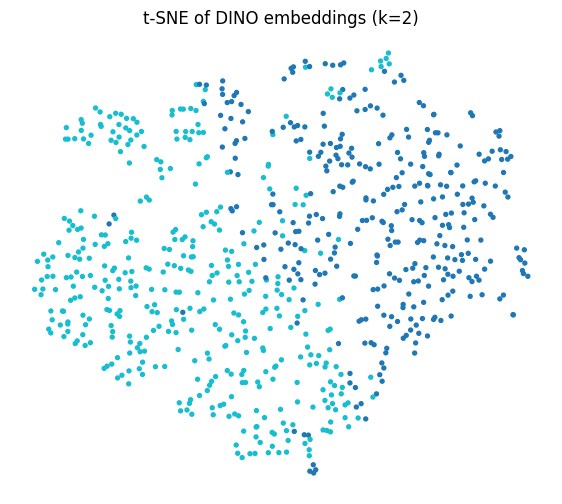

,Bulk,Extra,IExtra,Mis
0,118,76,43,117
1,107,119,100,84


In [61]:
import matplotlib.pyplot as plt

# t-SNE
from sklearn.manifold import TSNE
ts = TSNE(n_components=2, perplexity=30, init="pca", learning_rate="auto", random_state=0)
Y = ts.fit_transform(Z)

plt.figure(figsize=(7,6))
plt.scatter(Y[:,0], Y[:,1], c=pred, s=8, cmap="tab10")
plt.title(f"t-SNE of DINO embeddings (k={best_k})")
plt.axis("off")
plt.show()

# Optional: if true labels exist, show cluster-vs-label table
if y_true is not None and names is not None:
    import pandas as pd
    C = np.zeros((best_k, len(names)), dtype=int)
    for i in range(len(pred)):
        C[pred[i], int(y_true[i])] += 1
    df = pd.DataFrame(C, columns=names)
    display(df)


In [62]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# ---- assumes you already have:
# X (N,768), y_true (N,), names (list), and Z (N,32) from your previous run

# 1) compute bulk centroid in ORIGINAL embedding space (X)
bulk_id = names.index("Bulk")
X_bulk = X[y_true == bulk_id].astype(np.float32)

# L2 normalize for cosine
def l2norm_rows(A, eps=1e-8):
    n = np.linalg.norm(A, axis=1, keepdims=True)
    return A / (n + eps)

Xn = l2norm_rows(X.astype(np.float32))
bulk_centroid = Xn[y_true == bulk_id].mean(axis=0)
bulk_centroid = bulk_centroid / (np.linalg.norm(bulk_centroid) + 1e-8)

# 2) anomaly score = cosine distance to bulk centroid
cos_sim = (Xn * bulk_centroid[None, :]).sum(axis=1)          # in [-1,1]
anomaly = (1.0 - cos_sim).astype(np.float32)                 # in [0,2] approx

print("anomaly stats:", float(anomaly.min()), float(anomaly.mean()), float(anomaly.max()))

# 3) append anomaly to Z (your PCA space)
Z_aug = np.concatenate([Z, anomaly[:, None]], axis=1).astype(np.float32)
print("Z_aug:", Z_aug.shape)

# 4) re-run k sweep
Ks = list(range(2, 9))
scores = []
models = []
for k in Ks:
    km = KMeans(n_clusters=k, n_init=30, random_state=0).fit(Z_aug)
    s = silhouette_score(Z_aug, km.labels_)
    scores.append(s)
    models.append(km)
    print(f"k={k:2d}  silhouette={s:.4f}")

best_i = int(np.argmax(scores))
best_k = Ks[best_i]
pred_aug = models[best_i].labels_
print("\nBEST k =", best_k, "silhouette =", scores[best_i])


anomaly stats: 0.016650736331939697 0.06343165785074234 0.2096155881881714
Z_aug: (764, 33)
k= 2  silhouette=0.1530
k= 3  silhouette=0.1405
k= 4  silhouette=0.1226
k= 5  silhouette=0.1074
k= 6  silhouette=0.1150
k= 7  silhouette=0.1123
k= 8  silhouette=0.1159

BEST k = 2 silhouette = 0.15298499166965485


In [63]:
import pandas as pd
import numpy as np

C = np.zeros((best_k, len(names)), dtype=int)
for i in range(len(pred_aug)):
    C[pred_aug[i], int(y_true[i])] += 1

df = pd.DataFrame(C, columns=names)
display(df)


,Bulk,Extra,IExtra,Mis
0,118,76,43,117
1,107,119,100,84


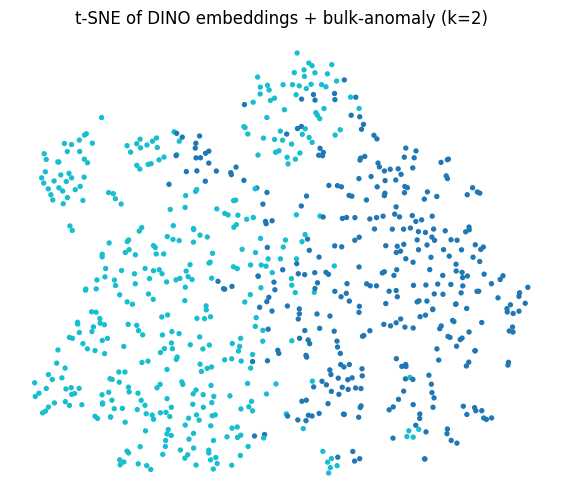

In [64]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

ts = TSNE(n_components=2, perplexity=30, init="pca", learning_rate="auto", random_state=0)
Y = ts.fit_transform(Z_aug)

plt.figure(figsize=(7,6))
plt.scatter(Y[:,0], Y[:,1], c=pred_aug, s=8, cmap="tab10")
plt.title(f"t-SNE of DINO embeddings + bulk-anomaly (k={best_k})")
plt.axis("off")
plt.show()


In [65]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

cl = AgglomerativeClustering(
    n_clusters=4,
    metric="cosine",
    linkage="average"
)
pred_cos = cl.fit_predict(Z_aug)

print("silhouette (cosine agglo):",
      silhouette_score(Z_aug, pred_cos, metric="cosine"))


silhouette (cosine agglo): 0.14928017556667328
